<a href="https://colab.research.google.com/github/yonatan-co/ViT_replication/blob/main/VIT_Paper_Replecation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

in this notebook i going to recreate the vison transformer presented at 
<a link=https://arxiv.org/abs/2010.11929>**"AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE"**</a>
of course this notebook would not be 1 to 1 replcation of this paper
but hopefully it will be close :) 

## project setup

In [ ]:
%pip install -q torchinfo

In [ ]:
%pip install -q wandb

     |████████████████████████████████| 1.9 MB 4.4 MB/s 
     |████████████████████████████████| 182 kB 88.4 MB/s 
     |████████████████████████████████| 174 kB 92.6 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 173 kB 90.8 MB/s 
     |████████████████████████████████| 168 kB 77.1 MB/s 
     |████████████████████████████████| 168 kB 92.6 MB/s 
     |████████████████████████████████| 166 kB 94.1 MB/s 
     |████████████████████████████████| 166 kB 80.8 MB/s 
     |████████████████████████████████| 162 kB 100.0 MB/s 
     |████████████████████████████████| 162 kB 95.8 MB/s 
     |████████████████████████████████| 158 kB 100.1 MB/s 
     |████████████████████████████████| 157 kB 69.8 MB/s 
     |████████████████████████████████| 157 kB 100.2 MB/s 
     |████████████████████████████████| 157 kB 100.3 MB/s 
     |████████████████████████████████| 157 kB 100.6 MB/s 
     |████████████████████████████████| 157 kB 97.8 MB/s 
     |██████

In [ ]:
import torch
from torchvision import transforms, datasets
from torchinfo import summary
from torch.nn import CrossEntropyLoss, Conv2d, Flatten, Module, Parameter, LayerNorm, MultiheadAttention, Sequential, Linear, GELU, Dropout
from torch.optim import Adam
from torch.utils.data import DataLoader

import numpy as np
import os 
import wandb
import matplotlib.pyplot as plt

In [ ]:
# import my humble utility module 
try:
    from torch_utils import data_setup, engine
except:
    print('cloning https://github.com/yonatan-co/torch_utils.git ...')
    !git clone https://github.com/yonatan-co/torch_utils.git
    !rm torch_utils/README.md

cloning https://github.com/yonatan-co/torch_utils.git ...
Cloning into 'torch_utils'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [ ]:
# setup environment variables
BATCH_SIZE = 32 # sorry i dont have money for 4096 size batchs 💗
IMG_SIZE = 224
LEARNING_RATE = 0.01
EPOCHS = 5
ATTENTION_HEADS = 12
MLP_SIZE = 3072

In [ ]:
# getting google's precious GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

## dataset setpup
first of all we need to get some data, we will use the cifar-10 Dataset. 

In [ ]:
# set up a transform
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
]) # Note: no normaliztion beacuse the model includes Layer normalization. 

print(f"data transform: {data_transform}")

data transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [ ]:
# train data
n_workers = os.cpu_count() # check how much workers avilable

train = datasets.CIFAR10(root="./data",
                         train=True,
                         transform=data_transform,
                         download=True)
train_dataloader = DataLoader(train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=n_workers)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# test data
test = datasets.CIFAR10(root="./data",
                         train=False,
                         transform=data_transform,
                         download=True)
test_dataloader = DataLoader(test,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=n_workers)

Files already downloaded and verified


In [ ]:
class_names = train.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

lets see some cifar10s or somethig

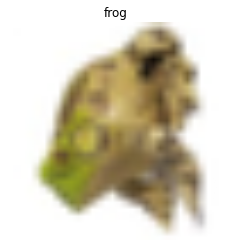

In [ ]:

# get a data sample
img_batch, label_batch = next(iter(train_dataloader)) 
img, label = img_batch[0], label_batch[0]

# plot it
plt.imshow(np.transpose(img.numpy()))
plt.axis(False)
plt.title(class_names[label.item()]);

nice, now to the fun part!

## Vit overview 

first of all one thing to know, in the paper the model feed of **patches** , i.e the image splited to smaller chunks.

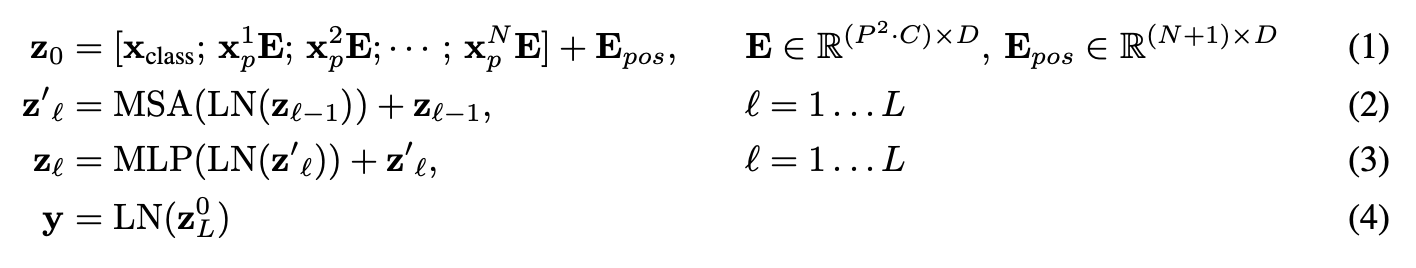

so in the vit paper we have these equations, they might look scary but they are actully just the model breaked down to pices.
lets go over it briefliy:

1.   so the first equation is about the class token, patch embedding and the position embedding in the input.
you can see it as the description of the embedding process.

2.   the second equation is more straight forward, any layer from one to L(i.e the total number of layers) going through a Layer Normalizer and then thorugh multi-headed attention. and to that we add the output of skip residual connection.

3. the third equation is very similer the previous one, we pass the output of the previous equation (i.e actually the previous block) into Layer Normalization
and then into Multi layer perceptron(i.e fancy way to say Linear/Dense model).
at the end we have another residual skip connection.

4. and the last equation is actually our output layer, a linear layer wrapped with another layer normalization.
*taking a breath*


## creating the Vision Transformer! 🥳

maybe not quite yet, we need to go through some steps first...

### splitting images to patches (demo)
first we must find a way to turn our images to patches...
so how we gonna do it?
well Conv2D layer actully does just that and it will take care of the patch embedding too because it will produce feature maps.

In [ ]:
C = 3 # input color channels
EMBEDDING_SIZE = 768 # in the paper its mentioned as 'Hidden Size D' 
PATCH_SIZE = 16

patcher = Conv2d(in_channels=C,
                 out_channels=EMBEDDING_SIZE,
                 kernel_size=PATCH_SIZE,
                 stride=PATCH_SIZE,
                 padding=0)

# Note: the reason why we set the stride to PATCH_SIZE is beacuse we want each 
# pixel to be belong exclusively to one patch.

so we got our patcher (idk if the term is a real thing).
the patcher get 2D image and outputs a 16 diffrent sets of 2D embeddings.

In [ ]:
# lets see it in action
feature_maps = patcher(img.unsqueeze(0))
print(f"{img.shape} --> {feature_maps.shape}")

torch.Size([3, 224, 224]) --> torch.Size([1, 768, 14, 14])


### Flatten & Rearrange our feature maps (demo)
currently out feature maps shape look somthing like this: (batch_size, 768, 14, 14), thats great but we still need to Flatten and Rearrange, at the end we want te recive
somthing like this (batch_size, 194, 768)

In [ ]:
# creating a layer to flatten (14,14) into 196 
flatten = Flatten(start_dim=2, 
                  end_dim=3)

flattened_feature_maps = flatten(feature_maps)
print(f"{feature_maps.shape} --> {flattened_feature_maps.shape}")

torch.Size([1, 768, 14, 14]) --> torch.Size([1, 768, 196])


In [ ]:
# all we have left is to rearrange the shape of the feature maps
rearanged_maps = flattened_feature_maps.permute(0, 2, 1) # dim 0 -> 0; dim 2 -> 1; dim 1 -> 2
print(f"{flattened_feature_maps.shape} --> {rearanged_maps.shape}")

torch.Size([1, 768, 196]) --> torch.Size([1, 196, 768])


### creating complete embedding model
cool, so we got our steps for patch embedding ready, now lets put it all together. 

In [ ]:
class PatchEmbedding(Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        # 3. Create a layer to turn an image into patches
        self.patcher = Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        
        self.flatten = Flatten(start_dim=2,
                                  end_dim=3)

    
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, 'squred image size must be divided by squred patch size'
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


In [ ]:
p = PatchEmbedding()
p(img.unsqueeze(0)).shape

torch.Size([1, 196, 768])

cool, coocoocool.
now we have a class to create patch embedding blocks what's next?

### class token embedding
what is class token embedding you ask?
well effectively just another trainable Parameter.
it will have the shape of (batch_size, 1, embedding_dim)

In [ ]:
class_token = Parameter(torch.ones(BATCH_SIZE, 1, EMBEDDING_SIZE),
                        requires_grad=True)

### position embeddings
the idea of postion embeddings is to give our model sense of localation, what is known to be the main drowback of vision transformers.

In [ ]:
number_of_patches = int((IMG_SIZE * IMG_SIZE) / PATCH_SIZE**2)

position_embedding = Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             EMBEDDING_SIZE),
                                  requires_grad=True)


So we have our embedding ready, now we need to take care of the second equation,
the multi-head attention block.
### MSA block


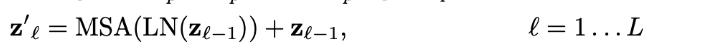

the MSA block is pretty straight forword, a layer normalization followed by a multi-head attention layer.

In [ ]:
class MSABlock(Module):
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12,
               attention_dropout: int=0) -> None:
    super().__init__()

    self.layer_normalization = LayerNorm(normalized_shape=embedding_dim)

    self.attention = MultiheadAttention(embed_dim=embedding_dim,
                                        num_heads=num_heads,
                                        dropout=attention_dropout,
                                        batch_first=True)
  def forward(self, input):
    x = self.layer_normalization(input)
    x = self.attention(query=x, 
                          key=x, 
                          value=x, 
                          need_weights=False)
    return x[0] # the MultiheadAttention layer returns a tuple
    

### MLP Block

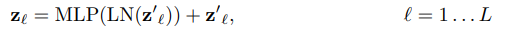

MLP stands for Multilayer Perceptron, sounds fancy but it really is just a Dense model (or Linear if you wish) that is not 'Deep' enough.
specifically in the Vit Paper, the MLPs contein 2 Linear layers each followed
by GELU non-linearity and a dropout layer.
ah and here we also pass the input through layer normalization first.

In [ ]:

class MLPBlock(Module):
  def __init__(self,
               embedding_dim: int=768,
               mlp_size: int=3072,
               dropout_rate: int=0.1) -> None:
    super().__init__()

    self.layer_normalization = LayerNorm(embedding_dim)

    self.mlp_block = Sequential(
        Linear(in_features=embedding_dim,
               out_features=mlp_size),
        GELU(),
        Dropout(dropout_rate),
        Linear(in_features=mlp_size,
               out_features=embedding_dim),
        GELU(),
        Dropout(dropout_rate),
    )

  def forward(self, input):
    x = self.layer_normalization(input)
    x = self.mlp_block(x)
    return x

### bulding the transformer encoder
we prepared all the bulding blocks necessery to bulid our transformer.
lets take a look at its architecture:

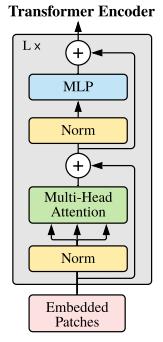

so, besides the blocks we prepared we also have residual connections(the '+' signs), the idea is very simple add the output of the layer to the input.

In [ ]:
class TransformerEncoder(Module):
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12,
               attention_dropout: int=0,
               mlp_size: int=3072,
               dropout_rate: int=0.1) -> None:
    super().__init__()
    self.msa_block = MSABlock(embedding_dim=embedding_dim,
                              num_heads=num_heads,
                              attention_dropout=attention_dropout)
    
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout_rate=dropout_rate)
  
  def forward(self, input):
    msa_output = self.msa_block(input) + input # '+input' is the residual connection

    mlp_output = self.mlp_block(msa_output)
    output = mlp_output + msa_output
    return output

### its VIT Time! 😈
now we are going to put all of this together into one model.

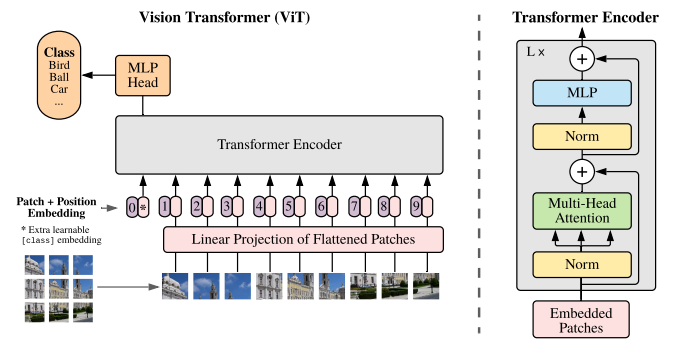

In [ ]:
class VisionTransformer(Module):
  def __init__(self,
               layers: int=12,
               in_channels: int=3,
               out_shape: int=10,
               patch_size: int=16,
               embedding_dim: int=768,
               num_heads: int=12,
               attention_dropout: int=0,
               mlp_size: int=3072,
               dropout_rate: int=0.1,
               img_size: int=224) -> None:
    super().__init__()

    self.n_patchs = int((img_size**2) / (patch_size**2))

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                               patch_size=patch_size,
                                               embedding_dim=embedding_dim)
    
    self.class_token_embedding = Parameter(torch.randn(1, 1, embedding_dim),
                                           requires_grad=True)
    
    self.position_embedding = Parameter(data=torch.randn(1,
                                             self.n_patchs+1, 
                                             embedding_dim
                                             ).type(torch.float),
                                  requires_grad=True)
    
    self.dropout = Dropout(dropout_rate)
    
    self.transformer_encoder = Sequential(*[TransformerEncoder(embedding_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  attention_dropout=attention_dropout,
                                                  mlp_size=mlp_size,
                                                  dropout_rate=dropout_rate) for i in range(layers)])

    self.classifier = Sequential(
        LayerNorm(normalized_shape=embedding_dim),
        Linear(in_features=embedding_dim,
               out_features=out_shape)
    )

  def forward(self, z):
    batch_size = z.shape[0]
        
      
    class_token = self.class_token_embedding.expand(batch_size, -1, -1) 
    z = self.patch_embedding(z)

    z = torch.cat((class_token, z), dim=1)

    z = + self.position_embedding + z 

    z = self.transformer_encoder(z)


    y = self.classifier(z[:, 0])

    return y



yah, so our model is ready now its time to train it
 

## training the Vision Transformer 🔨

### model show-off 🥶

In [ ]:
vit = VisionTransformer()
vit = vit.to(device)
# summary(model=vit, 
#         input_size=(32, 3, 224, 224), 
#         col_names=["input_size"], 
#         col_width=20,
#         row_settings=["var_names"])

### now to the training 

i will use my premade training loop, just a simple one nothing speical...

In [ ]:
from torch_utils.engine import train

In [ ]:
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=1e-3, 
                             betas=(0.9, 0.999), 
                             weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=EPOCHS,
                device=device,
                use_wandb=False # requires wandb.init() 
                )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0298 | train_acc: 0.2231 | test_loss: 2.0005 | test_acc: 0.2373
Epoch: 2 | train_loss: 2.0299 | train_acc: 0.2285 | test_loss: 1.9924 | test_acc: 0.2425


KeyboardInterrupt: ignored

the results may be dissapointing beacuse this architecture desigend for much larger datasets, just like lang transformers trained on huge datasets before being fine tuned on task specific datasets, but good results in this notebook is defiently achiveable, its just need much longer training time.